In [15]:
import tensorflow as tf
import numpy as np
from estimator_svdd_naive import naive_svdd_model_fn

tf.set_random_seed(1)
np.random.seed(1)

In [16]:
n_inputs        = 100
target_w        = 224
batch_size      = 10
train_steps     = 1000
model_dir       = "../tmp/estimator_svdd_naive"

In [17]:
# Simulate fake data coming from a flatten layer of a CNN
x_train = np.random.multivariate_normal(mean=[1., 1.], cov=np.eye(2), size=n_inputs).astype(np.float32)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_train,
    y=None,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=False
)

x_eval = np.vstack([
    np.random.multivariate_normal(mean=[1., 1.], cov=np.eye(2), size=950).astype(np.float32),
    np.random.multivariate_normal(mean=[10., 10.], cov=np.eye(2), size=50).astype(np.float32),
])
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=None,
    batch_size=50,
    num_epochs=1,
    shuffle=False
)

In [18]:
OCClassifier = tf.estimator.Estimator(
    model_fn=naive_svdd_model_fn,
    params={
        "frac_err": 50,
        "n_inputs": n_inputs,
        "kernel": "linear",
        "rffm_dims": 200,
        "rffm_stddev": 25,
        "learning_rate": 0.1
    },
    model_dir=None
)

OCClassifier.train(
    input_fn=train_input_fn,
    steps=train_steps
)
tf.logging.set_verbosity(tf.logging.DEBUG)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmpszmmz_6o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x121c2d080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/_f/

In [19]:
predictions = OCClassifier.predict(
    input_fn=test_input_fn
)
predictions_list = list(predictions)
predictions_distance = np.asarray(list(map(lambda p: p["predicted_distance"], predictions_list)))
predictions_classes = np.asarray(list(map(lambda p: p["predicted_classes"], predictions_list)))
mapped_inputs = np.asarray(list(map(lambda p: p["mapped_inputs"], predictions_list)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_f/7t_whmpx0zn2ln3npht19g8h0000gn/T/tmpszmmz_6o/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [20]:
OCClassifier.get_variable_value('Radius'), OCClassifier.get_variable_value('Center')

(1.6687746e-19, array([1.2109517, 1.0064894], dtype=float32))

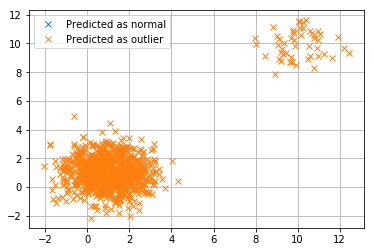

In [21]:
import matplotlib.pyplot as plt

ind_normal = predictions_classes > 0
ind_outlier = predictions_classes < 0
plt.plot(x_eval[ind_normal, 0], x_eval[ind_normal, 1], "x", label="Predicted as normal")
plt.plot(x_eval[ind_outlier, 0], x_eval[ind_outlier, 1], "x", label="Predicted as outlier")
plt.legend()
g = plt.grid()
plt.show()